In [1]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer

In [2]:
batch_size = 256
learning_rate = 2e-3
weight_decay = 1e-2
labels_count = 10
num_epochs = 100
fuzzy_dim = 2
fuzzy_rules_count = 100

prefix = "mamdani_mnist"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [4]:
def get_target(target_label):
    """
    Возвращает вектор целевого значения

    Args:
        target_label (int): Метка класса
    
    Returns:
        tensor (1, 10)
    """
    t = F.one_hot(torch.LongTensor([target_label]), labels_count)
    return t.to(device)

In [5]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target(x))
)

In [6]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target(x))
)
len(test_data)

10000

In [7]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [8]:
class Encoder(nn.Module):
    """
    Компонент энкодера
    
    Args:
        fuzzy_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, fuzzy_dim):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(9216, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(),  
            nn.Linear(625, fuzzy_dim),
        )
         
    def forward(self, x):
        """
        Выход энкодера
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            encoded input
        """

        ex = self.encoder(x)
        
        return ex

In [9]:
class MamdaniFIS(nn.Module):
    """
    MamdaniFIS
    
    Args:
        fuzzy_dim (int): Размер латентного вектора.
        labels_count (int): Количество выходов классификатора
    """
    def __init__(self, fuzzy_dim, fuzzy_rules_count, labels_count):
        super(MamdaniFIS, self).__init__()

        self.encoder = Encoder(fuzzy_dim)        
        
        self.fuzzy = nn.Sequential(
            FuzzyLayer.from_dimensions(fuzzy_dim, fuzzy_rules_count, trainable=True),
            #nn.Softmax(1),
            #nn.Linear(fuzzy_rules_count, labels_count, bias=False)
            DefuzzyLinearLayer.from_dimensions(fuzzy_rules_count, labels_count)
        )
        
    def forward(self, x):
        """
        
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            labels
        """

        ex = self.encoder(x)
        labels = self.fuzzy(ex)

        return labels

In [10]:
def compute_loss(target_labels, predicted_labels):

    ceLoss = nn.CrossEntropyLoss()
    
    loss_fuzzy = ceLoss.forward(predicted_labels, torch.squeeze(target_labels,1).float())

    return loss_fuzzy
    

In [11]:
model = MamdaniFIS(fuzzy_dim, fuzzy_rules_count, labels_count).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 5,832,375


MamdaniFIS(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): SiLU()
      (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (3): SiLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (5): SiLU()
      (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=9216, out_features=625, bias=True)
      (11): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): SiLU()
      (13): Linear(in_features=625, out_features=2, bias=True)
    )
  )
  (fuzzy): Sequential(
    (0): FuzzyLayer()
    (1): Softmax(dim=1)
    (2): Linear(in_features=100, out_features=10, bias=False)
  )
)

In [12]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [13]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        labels = model.forward(data)  
        
        loss = compute_loss(target, labels)
        
        loss.backward()
        
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            #print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [14]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_loss = 0
    test_accuracy = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            
            labels = model.forward(data)  
            
            loss = compute_loss(target, labels)
            
            test_loss += loss.item()
            
            pred_target = np.argmax(labels.cpu().numpy(), axis=1)
            target_labels =  np.argmax(torch.squeeze(target,1).cpu().numpy(), axis=1)
            test_accuracy += np.sum(target_labels==pred_target) / len(pred_target)

    test_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    print(f'====> Test set loss: {test_loss:.4f} (Accuracy {test_accuracy:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Accuracy', test_accuracy, global_step=cur_step)

In [15]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 2.2247 (Accuracy 0.3700)
Epoch 2/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 2.0802 (Accuracy 0.4886)
Epoch 3/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.9547 (Accuracy 0.5203)
Epoch 4/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.8552 (Accuracy 0.5070)
Epoch 5/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.7612 (Accuracy 0.5066)
Epoch 6/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.6786 (Accuracy 0.5080)
Epoch 7/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.6061 (Accuracy 0.5104)
Epoch 8/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.5512 (Accuracy 0.5099)
Epoch 9/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.4746 (Accuracy 0.5112)
Epoch 10/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.4335 (Accuracy 0.5110)
Epoch 11/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.3927 (Accuracy 0.5114)
Epoch 12/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.3435 (Accuracy 0.5123)
Epoch 13/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.3052 (Accuracy 0.5109)
Epoch 14/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.2778 (Accuracy 0.5617)
Epoch 15/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.2331 (Accuracy 0.5125)
Epoch 16/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.2089 (Accuracy 0.5112)
Epoch 17/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.1757 (Accuracy 0.5137)
Epoch 18/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.1530 (Accuracy 0.5111)
Epoch 19/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.1394 (Accuracy 0.5122)
Epoch 20/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.1147 (Accuracy 0.5137)
Epoch 21/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.1039 (Accuracy 0.5374)
Epoch 22/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.0877 (Accuracy 0.5135)
Epoch 23/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.0773 (Accuracy 0.5132)
Epoch 24/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.0593 (Accuracy 0.5133)
Epoch 25/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.0512 (Accuracy 0.5133)
Epoch 26/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.0361 (Accuracy 0.5146)
Epoch 27/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.0303 (Accuracy 0.5204)
Epoch 28/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.0223 (Accuracy 0.5168)
Epoch 29/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.0077 (Accuracy 0.5981)
Epoch 30/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 1.0023 (Accuracy 0.6051)
Epoch 31/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.9851 (Accuracy 0.6078)
Epoch 32/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.9652 (Accuracy 0.6119)
Epoch 33/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.9567 (Accuracy 0.6069)
Epoch 34/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.9418 (Accuracy 0.5939)
Epoch 35/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.9191 (Accuracy 0.6146)
Epoch 36/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.9070 (Accuracy 0.6145)
Epoch 37/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.8915 (Accuracy 0.6135)
Epoch 38/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.8800 (Accuracy 0.6156)
Epoch 39/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.8689 (Accuracy 0.6272)
Epoch 40/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.8573 (Accuracy 0.6182)
Epoch 41/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.8427 (Accuracy 0.6259)
Epoch 42/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.8320 (Accuracy 0.6163)
Epoch 43/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.8220 (Accuracy 0.6234)
Epoch 44/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.8130 (Accuracy 0.6061)
Epoch 45/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.8045 (Accuracy 0.6225)
Epoch 46/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.8014 (Accuracy 0.6129)
Epoch 47/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.7953 (Accuracy 0.6169)
Epoch 48/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.7871 (Accuracy 0.6207)
Epoch 49/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.7785 (Accuracy 0.6332)
Epoch 50/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.7638 (Accuracy 0.6678)
Epoch 51/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.7536 (Accuracy 0.7270)
Epoch 52/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.7402 (Accuracy 0.6955)
Epoch 53/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.7303 (Accuracy 0.7259)
Epoch 54/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.7224 (Accuracy 0.7504)
Epoch 55/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.7072 (Accuracy 0.7753)
Epoch 56/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.6942 (Accuracy 0.7740)
Epoch 57/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.6782 (Accuracy 0.7903)
Epoch 58/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.6588 (Accuracy 0.8101)
Epoch 59/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.6425 (Accuracy 0.8473)
Epoch 60/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.6202 (Accuracy 0.8842)
Epoch 61/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.6055 (Accuracy 0.8464)
Epoch 62/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.5982 (Accuracy 0.8712)
Epoch 63/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.5725 (Accuracy 0.8877)
Epoch 64/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.5596 (Accuracy 0.8506)
Epoch 65/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.5451 (Accuracy 0.8931)
Epoch 66/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.5303 (Accuracy 0.8791)
Epoch 67/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.5159 (Accuracy 0.8975)
Epoch 68/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.4941 (Accuracy 0.8855)
Epoch 69/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.4782 (Accuracy 0.9129)
Epoch 70/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.4610 (Accuracy 0.8859)
Epoch 71/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.4492 (Accuracy 0.9084)
Epoch 72/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.4307 (Accuracy 0.8961)
Epoch 73/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.4139 (Accuracy 0.9084)
Epoch 74/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.4016 (Accuracy 0.9098)
Epoch 75/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.3894 (Accuracy 0.9040)
Epoch 76/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.3800 (Accuracy 0.8991)
Epoch 77/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.3713 (Accuracy 0.9234)
Epoch 78/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.3613 (Accuracy 0.9380)
Epoch 79/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.3530 (Accuracy 0.9686)
Epoch 80/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.3436 (Accuracy 0.9677)
Epoch 81/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.3314 (Accuracy 0.9761)
Epoch 82/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.3277 (Accuracy 0.9701)
Epoch 83/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.3156 (Accuracy 0.9809)
Epoch 84/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.3091 (Accuracy 0.9833)
Epoch 85/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.3026 (Accuracy 0.9842)
Epoch 86/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.2924 (Accuracy 0.9833)
Epoch 87/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.2786 (Accuracy 0.9848)
Epoch 88/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.2687 (Accuracy 0.9823)
Epoch 89/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.2589 (Accuracy 0.9841)
Epoch 90/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.2550 (Accuracy 0.9855)
Epoch 91/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.2401 (Accuracy 0.9842)
Epoch 92/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.2355 (Accuracy 0.9843)
Epoch 93/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.2241 (Accuracy 0.9852)
Epoch 94/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.2159 (Accuracy 0.9841)
Epoch 95/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.2047 (Accuracy 0.9852)
Epoch 96/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.2042 (Accuracy 0.9839)
Epoch 97/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.1969 (Accuracy 0.9843)
Epoch 98/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.1879 (Accuracy 0.9849)
Epoch 99/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.1858 (Accuracy 0.9838)
Epoch 100/100


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 0.1758 (Accuracy 0.9854)


In [16]:
# encode and plot the z values for the train set 
model.eval()
features2d = []
labels_predicted = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        ft = model.encoder.forward(data)
        labs = model.forward(data)
        features2d.append(ft.cpu().numpy())
        labels_predicted.append(np.argmax(labs.cpu().numpy(), axis=1))
        labels_expected.append(np.argmax(target.squeeze(1).cpu().numpy(), axis=1))

features2d = np.concatenate(features2d, axis=0)
labels_predicted = np.concatenate(labels_predicted, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)
        

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

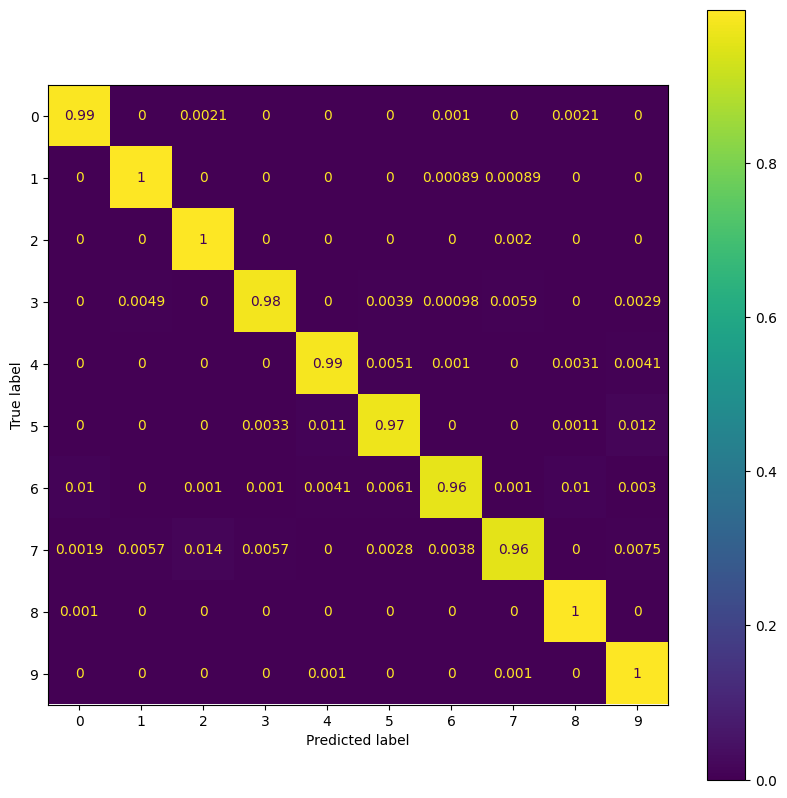

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels_predicted, labels_expected, normalize='true')
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)

Text(0, 0.5, 'feature 2')

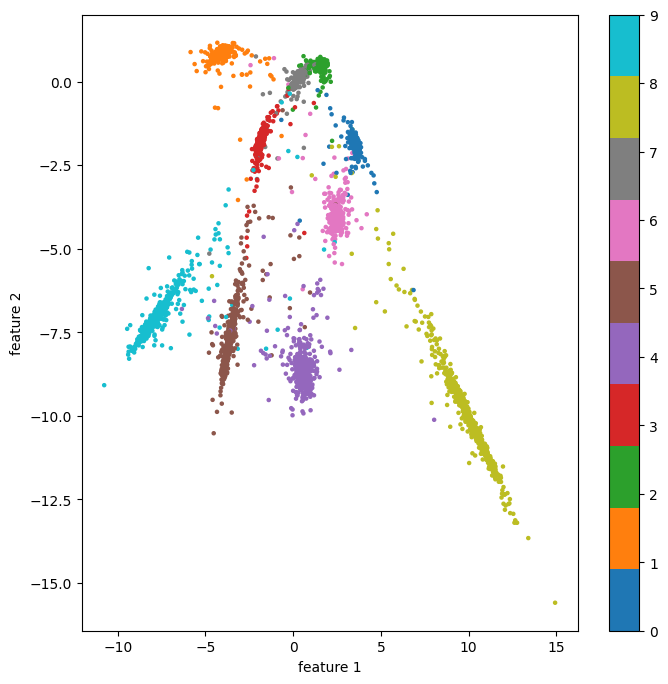

In [20]:
plt.figure(figsize=(8, 8))
plt.scatter(features2d[:, 0], features2d[:, 1], c=labels_expected, cmap='tab10', s=5)
plt.colorbar()
plt.xlabel("feature 1")
plt.ylabel("feature 2")